In [5]:
# Импортируем необходимые библиотеки
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
# from bertopic import BERTopic
import numpy as np
import re
from umap import UMAP
import hdbscan
from sklearn.cluster import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


In [2]:
from pymongo import MongoClient

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
collection = client['VKR1']['ner_results']

# Загрузка документов
documents = list(collection.find())

# Формирование корпуса (только сущности)
corpus = []
for doc in documents:
    # Проверяем наличие поля entities
    if 'entities' in doc:
        # Собираем все текстовые сущности
        entities_texts = [entity['text'] for entity in doc['entities']]
        # Объединяем сущности в строку
        document_text = " ".join(entities_texts)
        corpus.append(document_text)

# Формирование корпуса с тегами типов сущностей
corpus_with_labels = []
for doc in documents:
    if 'entities' in doc:
        # Собираем сущности с их типами
        entities_with_labels = [f"{entity['label']}:{entity['text']}" for entity in doc['entities']]
        document_text = " ".join(entities_with_labels)
        corpus_with_labels.append(document_text)

# Проверяем результат
print("Корпус (только сущности):")
for i, doc in enumerate(corpus[:5], start=1):  # Покажем первые 5 документов
    print(f"Document {i}: {doc}")

print("\nКорпус с тегами типов сущностей:")
for i, doc in enumerate(corpus_with_labels[:5], start=1):  # Покажем первые 5 документов
    print(f"Document {i}: {doc}")


Корпус (только сущности):
Document 1: assurance slab big data platforms assurance techniques analytics big data assurance service level agreements slas model
Document 2: data integrity analytics services cloud technologies data analytics many processes extra information public cloud infrastructures private spark resource correct data faults
Document 3: smart asset management electric utilities condition monitoring assets amounts chunk rich data information is analytics machine learning techniques internet of things pathways engineering
Document 4: academic learning analytics higher education business value model such analytics design business value creation legal competition risk security predictive analytics higher education fields higher education institutions big data academic
Document 5: big data analytics smart data technologies compute cloud edge devices inmotion processing atre st processing event driven programming reduce sequential code

Корпус с тегами типов сущностей:
Docume

Tag: ALGORITHM, BoW matrix shape: (39287, 3000)
Tag: TECHNOLOGY, BoW matrix shape: (429999, 3000)
Tag: METHOD, BoW matrix shape: (127637, 3000)
Tag: DATA, BoW matrix shape: (110381, 3000)
Tag: MODEL, BoW matrix shape: (98793, 3000)
Tag: APPLICATION, BoW matrix shape: (629222, 3000)
Tag: TASK, BoW matrix shape: (232192, 3000)
Tag: TOOL, BoW matrix shape: (134575, 3000)
Tag: FRAMEWORK, BoW matrix shape: (50306, 3000)
Tag: PARAMETER, BoW matrix shape: (44683, 3000)
Tag: METRIC, BoW matrix shape: (60918, 3000)

--- Processing Tag: ALGORITHM ---

Tag: ALGORITHM, Topic 0: methods (654.20), optimization (495.16), parallel (247.20), hierarchical (194.20), programming (177.20), swarm (172.20), reinforcement (160.20), optimal (153.20), particle (146.20), time (131.20)

Tag: ALGORITHM, Topic 1: algorithms (4231.69), based (529.20), ml (219.20), optimization (202.70), ml algorithms (184.20), models (172.20), optimization algorithms (116.20), ai (95.29), distributed (94.65), game (94.06)

Tag: ALGO

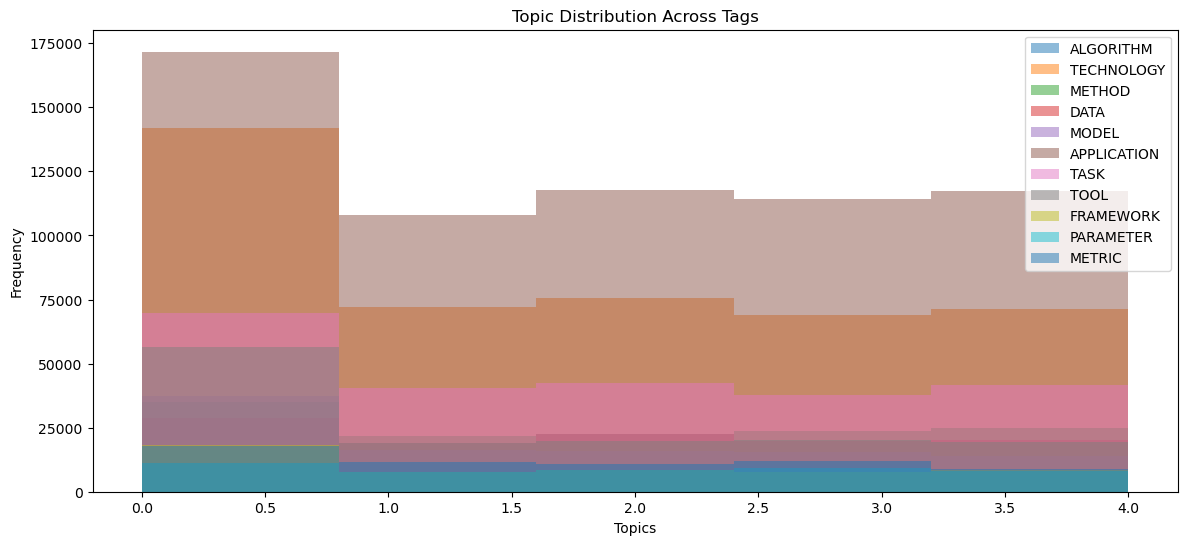

In [5]:
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
collection = client['VKR1']['ner_results']

# Загрузка документов
documents = list(collection.find())

# Шаг 1. Разделение текста по тегам
tagged_corpus = {tag: [] for tag in ['ALGORITHM', 'TECHNOLOGY', 'METHOD', 'DATA', 'MODEL', 'APPLICATION', 'TASK', 'TOOL', 'FRAMEWORK', 'PARAMETER', 'METRIC']}
for doc in documents:
    if 'entities' in doc:
        for entity in doc['entities']:
            tag = entity['label']
            text = entity['text']
            if tag in tagged_corpus:
                tagged_corpus[tag].append(text)

# Шаг 2. Создание BoW-матриц для каждого тега
custom_stop_words = [
    'tool', 'model', 'method', 'information', 'analysis', 
    'system', 'systems', 'digital', 'technologies', 'data', 'task'
]

vectorizers = {}
bow_matrices = {}
for tag, texts in tagged_corpus.items():
    vectorizer = CountVectorizer(
        max_features=3000,
        ngram_range=(1, 3),
        stop_words=custom_stop_words,
        token_pattern=r'\b\w+\b',
        min_df=2,
        max_df=0.85
    )
    bow_matrix = vectorizer.fit_transform(texts)
    vectorizers[tag] = vectorizer
    bow_matrices[tag] = bow_matrix
    print(f"Tag: {tag}, BoW matrix shape: {bow_matrix.shape}")

# Шаг 3. Упрощенная функция для быстрого анализа LDA
def quick_lda(matrix, vectorizer, tag, num_topics=5):
    lda = LatentDirichletAllocation(
        n_components=num_topics,
        max_iter=20,  # Уменьшено количество итераций для ускорения
        random_state=42,
        learning_method="batch"
    )
    lda.fit(matrix)

    # Анализ тем
    feature_names = vectorizer.get_feature_names_out()
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_features = [(feature_names[i], topic[i]) for i in topic.argsort()[:-10 - 1:-1]]
        topics[f"Topic {topic_idx}"] = top_features
        print(f"\nTag: {tag}, Topic {topic_idx}: {', '.join([f'{word} ({weight:.2f})' for word, weight in top_features])}")

# Шаг 4. Применение LDA по тегам
for tag, bow_matrix in bow_matrices.items():
    if bow_matrix.shape[0] > 0:  # Проверяем, есть ли данные
        print(f"\n--- Processing Tag: {tag} ---")
        quick_lda(bow_matrix, vectorizers[tag], tag)

# Итоговая визуализация для всех тегов
plt.figure(figsize=(14, 6))
for tag, bow_matrix in bow_matrices.items():
    lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=42)
    lda.fit(bow_matrix)
    plt.hist(np.argmax(lda.transform(bow_matrix), axis=1), bins=5, alpha=0.5, label=tag)
plt.title("Topic Distribution Across Tags")
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [9]:
import json
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
research_paper_collection = client['VKR1']['research_paper']
ner_results_collection = client['VKR1']['ner_results']

# Загрузка данных из MongoDB
def load_data():
    try:
        print("Загрузка данных из MongoDB...")
        research_papers = pd.DataFrame(list(research_paper_collection.find({}, {"_id": 1, "yearPublished": 1})))
        ner_results = pd.DataFrame(list(ner_results_collection.find({}, {"_id": 1, "entities": 1})))
        return research_papers, ner_results
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return pd.DataFrame(), pd.DataFrame()

research_papers, ner_results = load_data()

# Проверка данных
if research_papers.empty or ner_results.empty:
    print("Нет данных для анализа. Проверьте подключение и содержимое коллекций MongoDB.")
    exit()

# Объединение данных по _id
merged_data = pd.merge(research_papers, ner_results, on="_id")
print(f"Всего объединенных документов: {len(merged_data)}")

# Фильтрация документов с указанным годом публикации
merged_data = merged_data[merged_data["yearPublished"].notnull()]
print(f"Документы с указанным годом публикации: {len(merged_data)}")

# Шаг 1. Группировка текстов по категориям и годам
categories = ['ALGORITHM', 'TECHNOLOGY', 'METHOD', 'DATA', 'MODEL', 'APPLICATION', 'TASK', 'TOOL', 'FRAMEWORK', 'PARAMETER', 'METRIC']
tagged_corpus = {tag: {} for tag in categories}

print("Группировка текстов по категориям и годам...")
for _, row in tqdm(merged_data.iterrows(), total=len(merged_data)):
    year = row["yearPublished"]
    entities = row.get("entities", [])
    if not entities:
        continue
    for entity in entities:
        tag = entity.get("label")
        text = entity.get("text")
        if tag in tagged_corpus and text:
            tagged_corpus[tag].setdefault(year, []).append(text)

# Шаг 2. Определение оптимального числа тем
def find_optimal_topics(texts, vectorizer, min_topics=4, max_topics=15):
    if len(texts) < 5:
        return None, None, None, 0  # Недостаточно данных для анализа
    bow_matrix = vectorizer.fit_transform(texts)
    best_lda = None
    best_topics = None
    best_coherence = -np.inf
    best_num_topics = 0

    for num_topics in range(min_topics, max_topics + 1):
        lda = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=20,
            random_state=42,
            learning_method="batch"
        )
        lda.fit(bow_matrix)
        coherence = calculate_coherence(lda)
        if coherence > best_coherence:
            best_coherence = coherence
            best_lda = lda
            best_num_topics = num_topics
            feature_names = vectorizer.get_feature_names_out()
            best_topics = {
                f"Topic {i}": [
                    (feature_names[j], topic[j]) for j in topic.argsort()[:-11:-1]
                ]
                for i, topic in enumerate(lda.components_)
            }
    return best_lda, vectorizer, best_topics, best_num_topics

def calculate_coherence(model):
    """
    Вычисляет когерентность как среднюю плотность тем.
    """
    topic_word_distribution = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    coherence = np.mean(np.max(topic_word_distribution, axis=1))
    return coherence

# Шаг 3. Тематическое моделирование по годам
def perform_topic_modeling():
    topic_trends = {tag: {} for tag in categories}
    topic_keywords = {tag: {} for tag in categories}
    optimal_topics_count = {tag: {} for tag in categories}

    print("Проведение тематического моделирования...")
    for tag, yearly_texts in tagged_corpus.items():
        print(f"\n--- Анализ категории: {tag} ---")
        vectorizer = CountVectorizer(
            max_features=3000,
            ngram_range=(1, 3),
            stop_words='english',
            token_pattern=r'\b\w+\b',
            min_df=2,
            max_df=0.85
        )

        for year, texts in yearly_texts.items():
            lda, vec, topics, num_topics = find_optimal_topics(texts, vectorizer)
            if lda is not None:
                topic_distribution = lda.transform(vec.transform(texts)).mean(axis=0)
                topic_trends[tag][year] = topic_distribution.tolist()  # Преобразование для сериализации
                topic_keywords[tag][year] = topics
                optimal_topics_count[tag][year] = num_topics

    return topic_trends, topic_keywords, optimal_topics_count

topic_trends, topic_keywords, optimal_topics_count = perform_topic_modeling()

# Шаг 4. Сохранение результатов
def save_results(topic_trends, topic_keywords, optimal_topics_count):
    print("\nСохранение результатов...")
    try:
        with open("topic_trends.json", "w", encoding="utf-8") as f:
            json.dump(topic_trends, f, indent=4)
        with open("topic_keywords.json", "w", encoding="utf-8") as f:
            json.dump(topic_keywords, f, indent=4)
        with open("optimal_topics_count.json", "w", encoding="utf-8") as f:
            json.dump(optimal_topics_count, f, indent=4)
        print("Результаты успешно сохранены.")
    except Exception as e:
        print(f"Ошибка при сохранении результатов: {e}")

save_results(topic_trends, topic_keywords, optimal_topics_count)

Загрузка данных...
Всего объединенных документов: 86564
Документы с указанным годом публикации: 86564
Группировка текстов по категориям и годам...


100%|██████████| 86564/86564 [00:05<00:00, 14578.95it/s]


Проведение тематического моделирования...

--- Анализ категории: ALGORITHM ---

--- Анализ категории: TECHNOLOGY ---

--- Анализ категории: METHOD ---

--- Анализ категории: DATA ---

--- Анализ категории: MODEL ---

--- Анализ категории: APPLICATION ---

--- Анализ категории: TASK ---

--- Анализ категории: TOOL ---

--- Анализ категории: FRAMEWORK ---

--- Анализ категории: PARAMETER ---

--- Анализ категории: METRIC ---
Сохранение результатов в файлы...


TypeError: Object of type ndarray is not JSON serializable

Визуализация трендов...


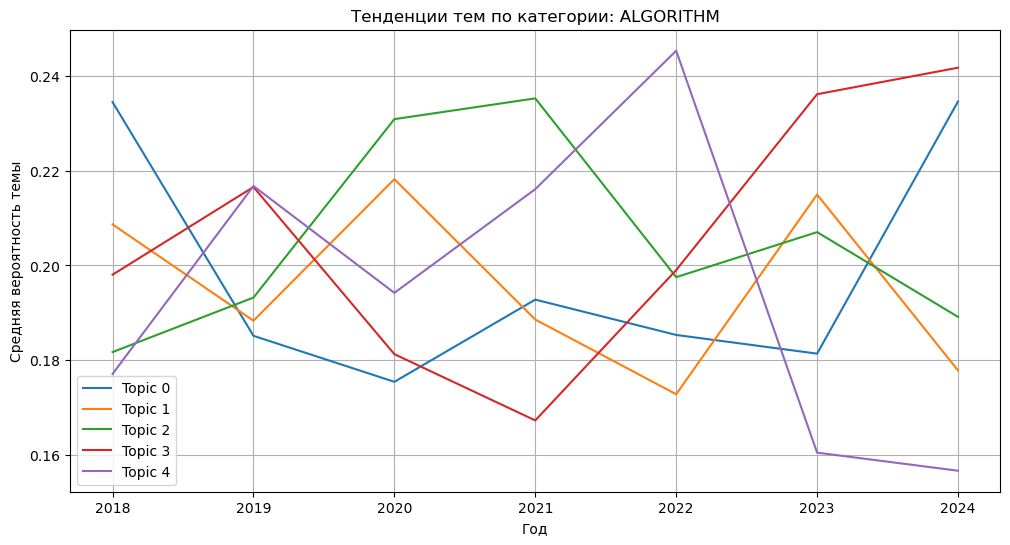

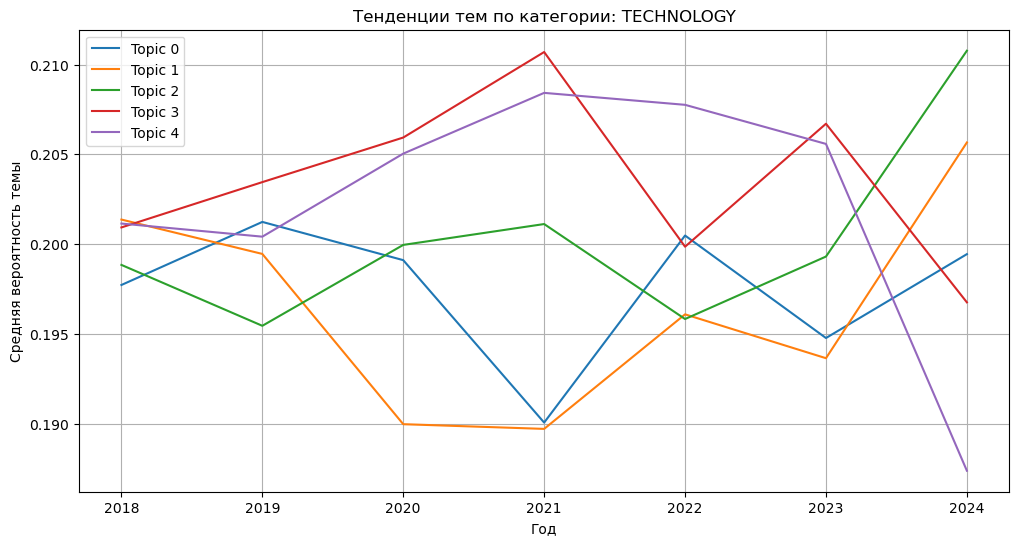

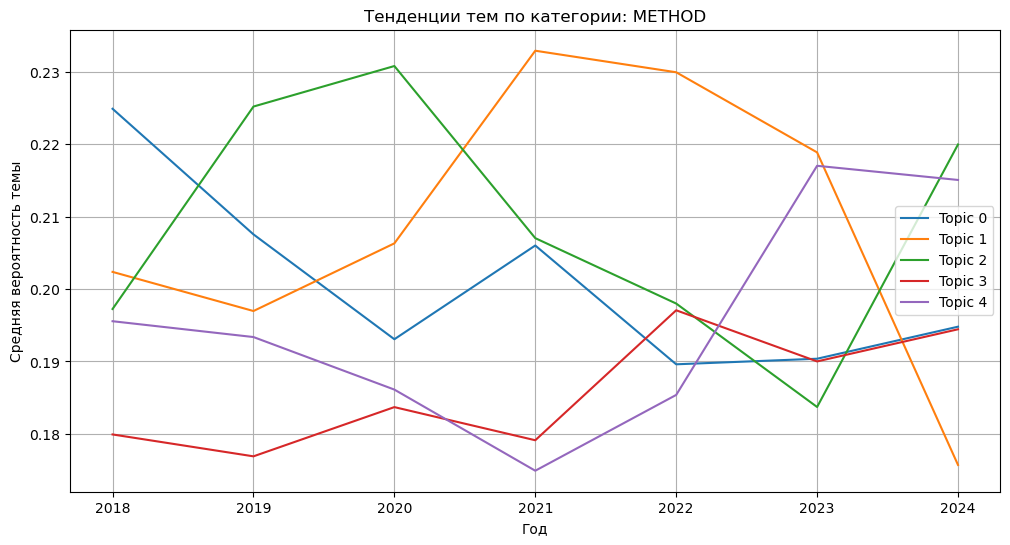

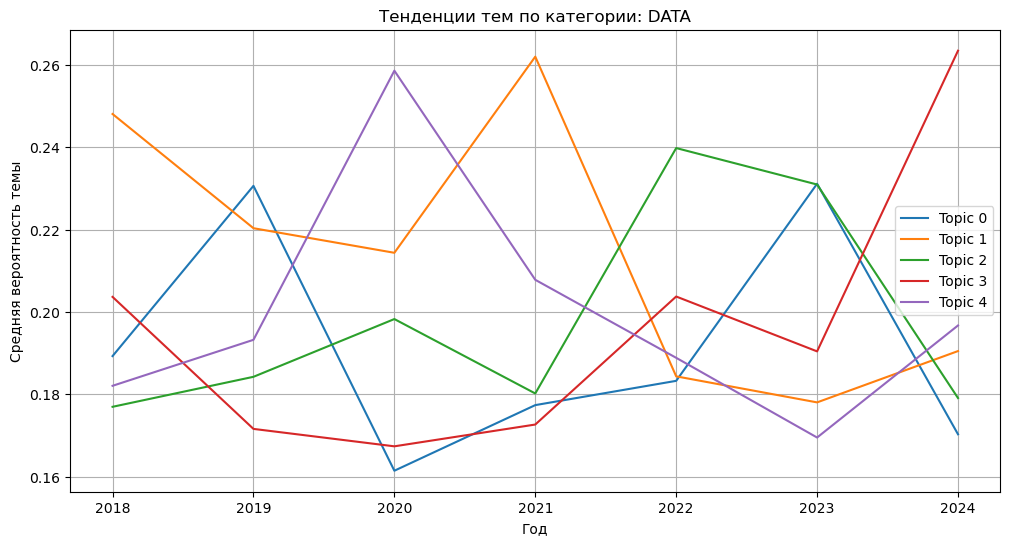

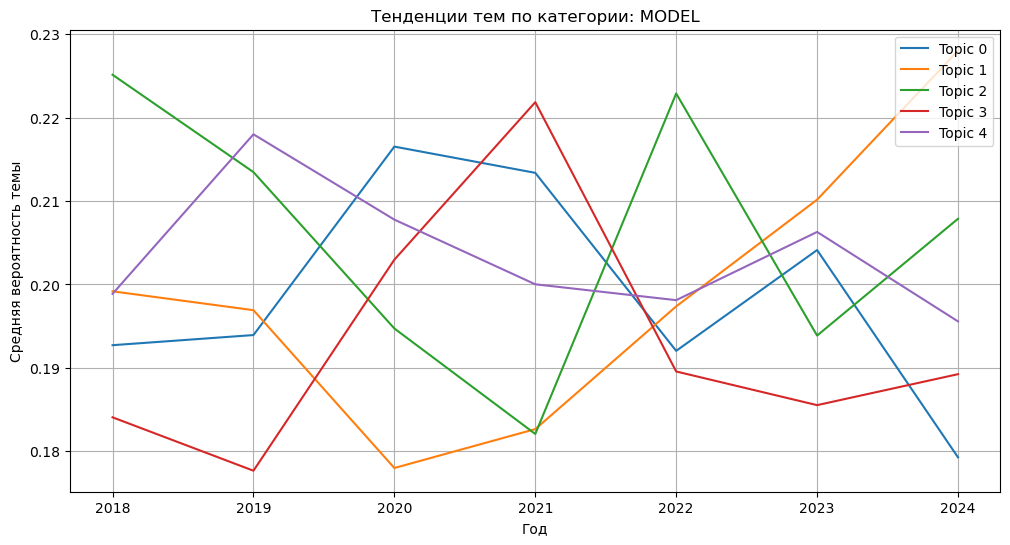

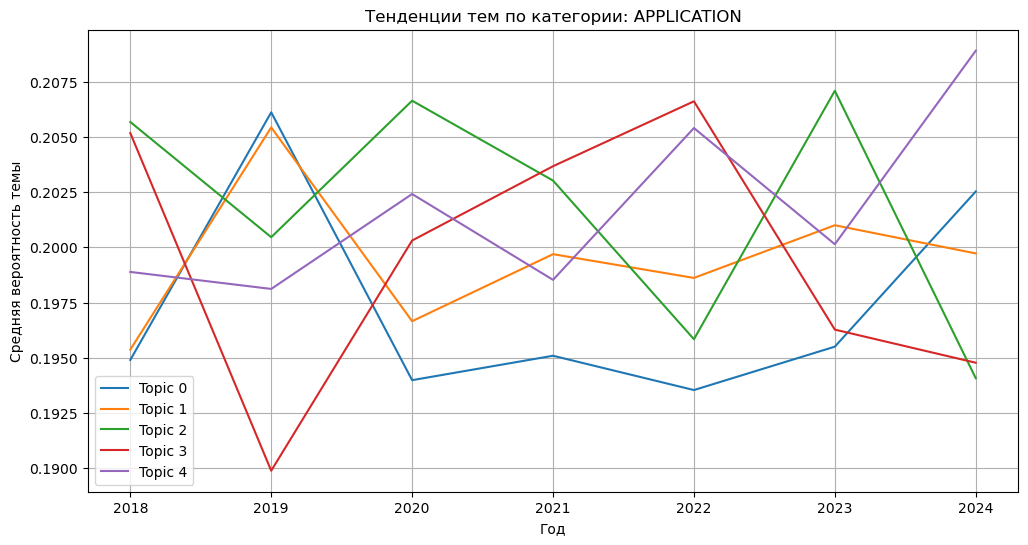

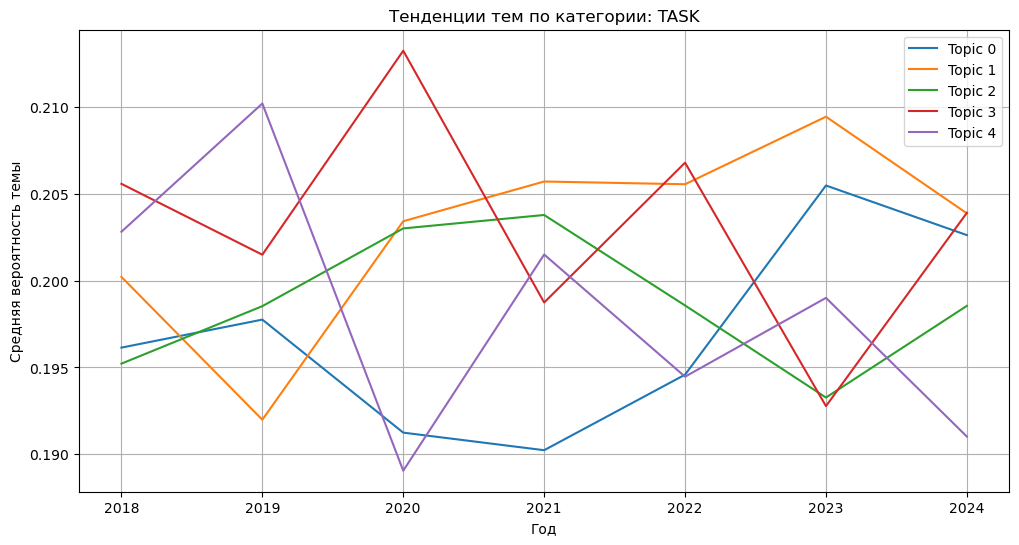

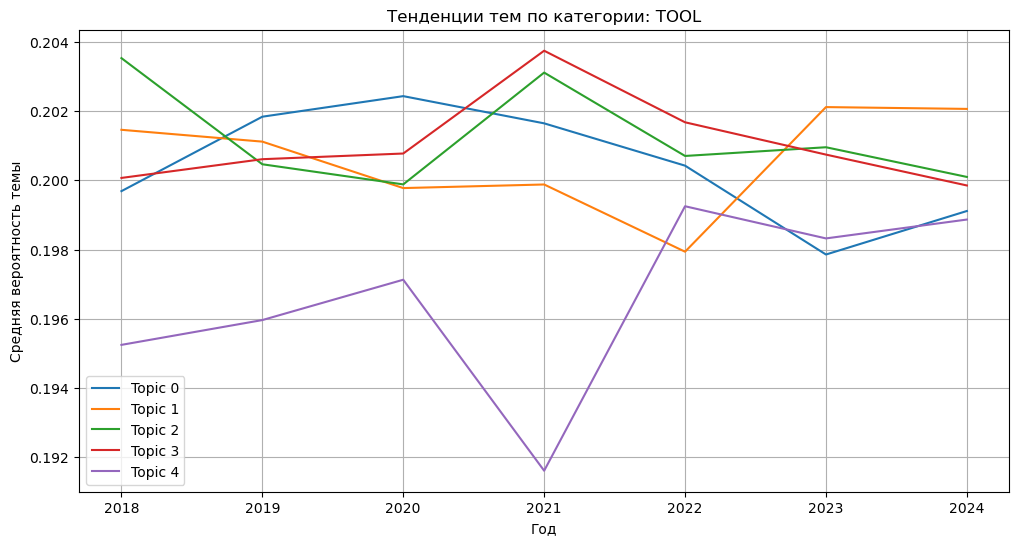

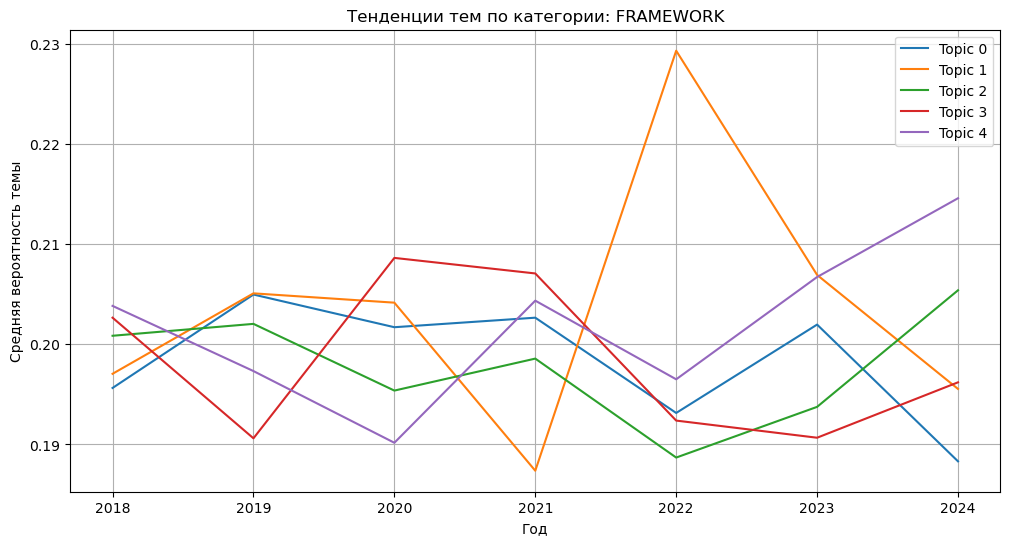

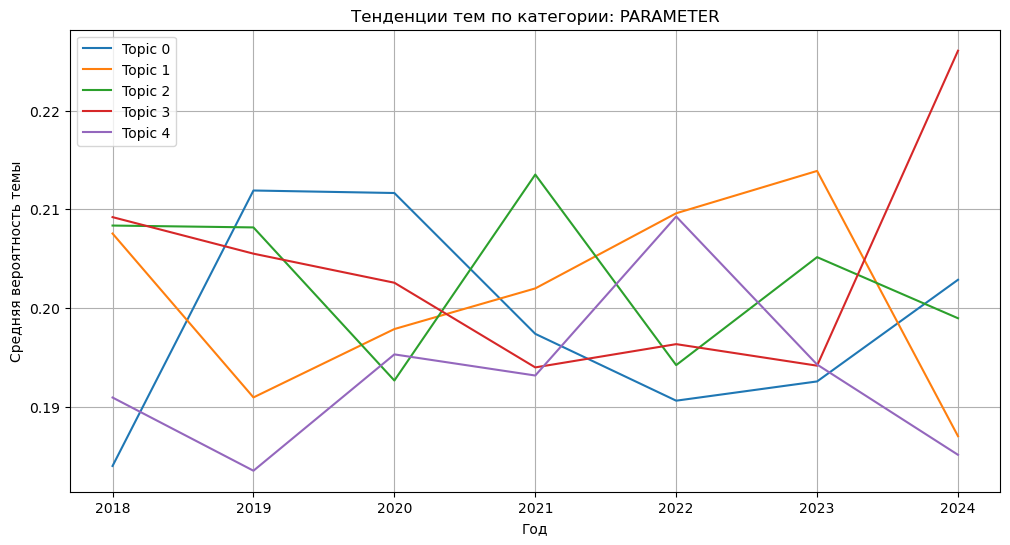

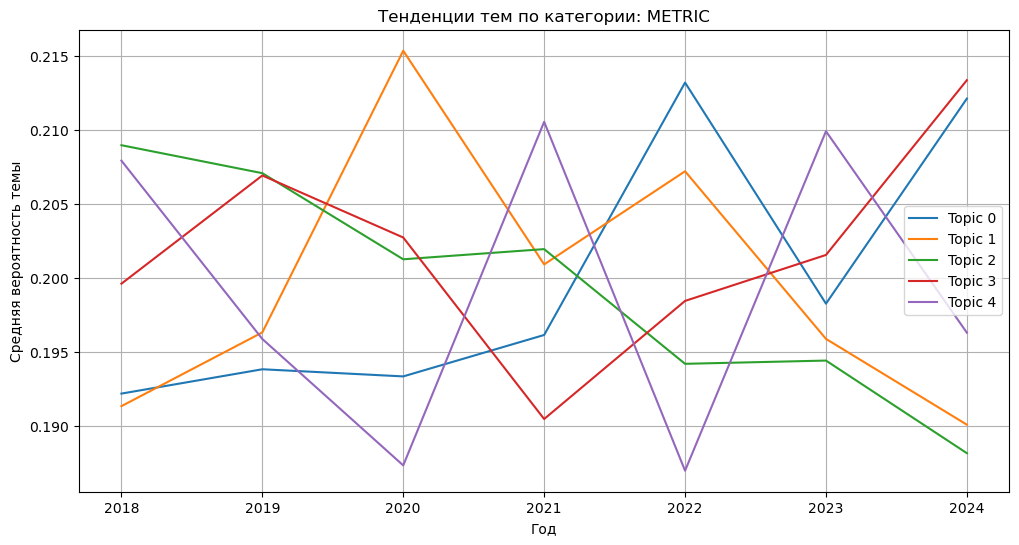

In [11]:
def plot_trends(topic_trends, num_topics=5):
    """
    Строит графики распределения тем по годам для каждой категории.
    """
    for tag, yearly_trends in topic_trends.items():
        if not yearly_trends:
            continue
        df_trends = pd.DataFrame(yearly_trends).T.sort_index()  # Данные в формате {год: [распределение тем]}
        plt.figure(figsize=(12, 6))
        for topic_idx in range(num_topics):
            plt.plot(
                df_trends.index, 
                df_trends[topic_idx], 
                label=f"Topic {topic_idx}"
            )
        plt.title(f"Тенденции тем по категории: {tag}")
        plt.xlabel("Год")
        plt.ylabel("Средняя вероятность темы")
        plt.legend()
        plt.grid()
        plt.show()

# Построение графиков
print("Визуализация трендов...")
plot_trends(topic_trends, num_topics=5)

In [1]:
from pymongo import MongoClient
import json

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
collection = client['VKR1']['LDA_results']

# Чтение данных из файла
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Загрузка данных из файлов
topic_keywords = load_json_file("topic_keywords.json")
topic_trends = load_json_file("topic_trends.json")

# Подготовка данных к записи в MongoDB
def save_to_mongo(data, collection):
    if isinstance(data, dict):
        # Если данные словарь, разбиваем на отдельные записи
        for key, value in data.items():
            document = {"key": key, "value": value}
            collection.insert_one(document)
    elif isinstance(data, list):
        # Если данные список, добавляем их напрямую
        collection.insert_many(data)
    else:
        raise ValueError("Unsupported data type for MongoDB insertion.")

# Сохранение данных в коллекцию
save_to_mongo(topic_keywords, collection)
save_to_mongo(topic_trends, collection)

print("Данные успешно сохранены в MongoDB.")


Данные успешно сохранены в MongoDB.


In [3]:
from pymongo import MongoClient
import json

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
collection = client['VKR1']['LDA_results']

# Загрузка данных из файлов
with open("topic_keywords.json", "r", encoding="utf-8") as f:
    topic_keywords = json.load(f)

with open("topic_trends.json", "r", encoding="utf-8") as f:
    topic_trends = json.load(f)

# Сборка документов для MongoDB
documents = []

for category, years in topic_keywords.items():
    for year, topics in years.items():
        for topic, keywords in topics.items():
            # Формируем topic_id
            topic_id = f"{category.lower()}_{year.lower()}_{topic.lower().replace(' ', '_')}"
            
            # Ищем тренд для текущей категории, года и темы
            trend = None
            if category in topic_trends and year in topic_trends[category]:
                trend_index = int(topic.split()[-1])  # Извлекаем номер темы из "Topic X"
                trend = topic_trends[category][year][trend_index]
            
            # Создаем документ
            document = {
                "topic_id": topic_id,
                "category": category,
                "year": year,
                "name": topic,
                "keywords": keywords,
                "trend": trend
            }
            documents.append(document)

# Сохраняем в MongoDB
collection.insert_many(documents)

print(f"Сохранено {len(documents)} документов в коллекцию 'merged_topics'LDA_results")


Сохранено 1094 документов в коллекцию 'merged_topics'.


In [41]:
import json
from pymongo import MongoClient
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import pandas as pd

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
db = client["VKR1"]
research_paper_collection = db["research_paper"]
ner_results_collection = db["ner_results"]

# Загрузка данных из MongoDB
def load_data():
    print("Загрузка данных из MongoDB...")
    try:
        research_papers = list(research_paper_collection.find({}, {"_id": 1, "yearPublished": 1}))
        ner_results = list(ner_results_collection.find({}, {"_id": 1, "entities": 1}))
        if not research_papers or not ner_results:
            raise ValueError("Коллекции MongoDB пусты или данные отсутствуют.")
        return pd.DataFrame(research_papers), pd.DataFrame(ner_results)
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return pd.DataFrame(), pd.DataFrame()

research_papers, ner_results = load_data()

if research_papers.empty or ner_results.empty:
    print("Данные не загружены. Проверьте подключение к MongoDB.")
    exit()

# Объединение данных
merged_data = pd.merge(research_papers, ner_results, on="_id")
print(f"Всего объединённых документов: {len(merged_data)}")

# Фильтрация по году публикации
merged_data = merged_data[merged_data["yearPublished"].notnull()]
print(f"Документы с указанным годом публикации: {len(merged_data)}")

# Группировка текстов по категориям и годам
categories = ['ALGORITHM', 'TECHNOLOGY', 'METHOD', 'DATA', 'MODEL', 'APPLICATION', 'TASK', 'TOOL', 'FRAMEWORK', 'PARAMETER', 'METRIC']
tagged_corpus = {tag: {} for tag in categories}

print("Группировка текстов по категориям и годам...")
for _, row in tqdm(merged_data.iterrows(), total=len(merged_data)):
    year = row["yearPublished"]
    entities = row.get("entities", [])
    if entities:
        for entity in entities:
            tag = entity.get("label")
            text = entity.get("text")
            if tag in tagged_corpus and text:
                tagged_corpus[tag].setdefault(year, []).append(text)

# Расчёт когерентности для трёх метрик
def calculate_coherence_gensim(texts, num_topics, alpha, beta):
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42, alpha=alpha, eta=beta)

    coherence_umass = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='u_mass').get_coherence()
    coherence_cv = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v').get_coherence()
    coherence_npmi = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_npmi').get_coherence()

    return coherence_umass, coherence_cv, coherence_npmi, lda_model

# Определение оптимального числа тем и параметров
param_grid = {
    'num_topics': range(4, 10),  # Уменьшить диапазон
    'alpha': ['symmetric', 0.1],
    'beta': ['symmetric', 0.1]
}


def find_optimal_topics_with_gensim(texts):
    if len(texts) < 5:
        return None, None, None  # Недостаточно данных

    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    best_params = None
    best_coherence = -float('inf')
    best_model = None

    for params in tqdm(ParameterGrid(param_grid)):
        coherence_umass, coherence_cv, coherence_npmi, lda_model = calculate_coherence_gensim(
            texts, params['num_topics'], params['alpha'], params['beta']
        )

        avg_coherence = (coherence_cv + coherence_npmi - coherence_umass) / 3  # Усреднённая метрика

        if avg_coherence > best_coherence:
            best_coherence = avg_coherence
            best_params = params
            best_model = lda_model

    return best_model.show_topics(num_topics=best_params['num_topics'], formatted=False), best_params, best_coherence

# Тематическое моделирование
def perform_topic_modeling_with_gensim():
    topic_keywords = {tag: {} for tag in categories}
    optimal_params = {tag: {} for tag in categories}
    topic_coherences = {tag: {} for tag in categories}

    print("Проведение тематического моделирования...")
    for tag, yearly_texts in tqdm(tagged_corpus.items()):
        for year, texts in yearly_texts.items():
            if texts:
                topics, params, coherence = find_optimal_topics_with_gensim(texts)
                if topics is not None:
                    topic_keywords[tag][year] = topics
                    optimal_params[tag][year] = params
                    topic_coherences[tag][year] = coherence

    return topic_keywords, optimal_params, topic_coherences

# Запуск моделирования
topic_keywords, optimal_params, topic_coherences = perform_topic_modeling_with_gensim()


Загрузка данных из MongoDB...
Всего объединённых документов: 86564
Документы с указанным годом публикации: 86564
Группировка текстов по категориям и годам...


100%|██████████| 86564/86564 [00:07<00:00, 11752.07it/s]


Проведение тематического моделирования...


100%|██████████| 24/24 [17:46<00:00, 44.42s/it]

100%|██████████| 24/24 [17:51<00:00, 44.64s/it]

100%|██████████| 24/24 [16:51<00:00, 42.13s/it]

100%|██████████| 24/24 [17:17<00:00, 43.25s/it]

100%|██████████| 24/24 [16:16<00:00, 40.68s/it]

100%|██████████| 24/24 [15:34<00:00, 38.94s/it]

100%|██████████| 24/24 [19:46<00:00, 49.45s/it]

100%|██████████| 24/24 [18:49<00:00, 47.04s/it]

100%|██████████| 24/24 [18:27<00:00, 46.15s/it]

100%|██████████| 24/24 [19:05<00:00, 47.74s/it]

100%|██████████| 24/24 [20:16<00:00, 50.69s/it]

100%|██████████| 24/24 [19:22<00:00, 48.45s/it]

100%|██████████| 24/24 [16:34<00:00, 41.43s/it]

100%|██████████| 24/24 [16:20<00:00, 40.84s/it]

100%|██████████| 24/24 [16:12<00:00, 40.51s/it]

100%|██████████| 24/24 [16:30<00:00, 41.27s/it]

100%|██████████| 24/24 [16:49<00:00, 42.07s/it]

100%|██████████| 24/24 [17:45<00:00, 44.41s/it]

100%|██████████| 24/24 [16:36<00:00, 41.54s/it]

100%|██████████| 24/24 [16:14<00:00, 40.60s/it]

100%|██████████| 24/

In [47]:
optimal_params

{'ALGORITHM': {2018: {'alpha': 0.1, 'beta': 'symmetric', 'num_topics': 8},
  2019: {'alpha': 'symmetric', 'beta': 0.1, 'num_topics': 6},
  2020: {'alpha': 'symmetric', 'beta': 'symmetric', 'num_topics': 9},
  2021: {'alpha': 'symmetric', 'beta': 0.1, 'num_topics': 7},
  2022: {'alpha': 'symmetric', 'beta': 0.1, 'num_topics': 7},
  2023: {'alpha': 'symmetric', 'beta': 'symmetric', 'num_topics': 6},
  2024: {'alpha': 0.1, 'beta': 'symmetric', 'num_topics': 4}},
 'TECHNOLOGY': {2018: {'alpha': 'symmetric', 'beta': 0.1, 'num_topics': 9},
  2019: {'alpha': 0.1, 'beta': 'symmetric', 'num_topics': 8},
  2020: {'alpha': 0.1, 'beta': 'symmetric', 'num_topics': 9},
  2021: {'alpha': 0.1, 'beta': 'symmetric', 'num_topics': 9},
  2022: {'alpha': 'symmetric', 'beta': 0.1, 'num_topics': 9},
  2023: {'alpha': 'symmetric', 'beta': 'symmetric', 'num_topics': 9},
  2024: {'alpha': 'symmetric', 'beta': 0.1, 'num_topics': 9}},
 'METHOD': {2018: {'alpha': 'symmetric', 'beta': 0.1, 'num_topics': 8},
  2019:

In [57]:
topic_keywords

{'ALGORITHM': {2018: [(0,
    [('search', 0.06683959),
     ('theory', 0.030193873),
     ('state', 0.025651297),
     ('solutions', 0.019002933),
     ('game', 0.018087879),
     ('numerical', 0.014931978),
     ('optimal', 0.014516413),
     ('pareto', 0.013445218),
     ('network', 0.0126486),
     ('online', 0.011505806)]),
   (1,
    [('reduce', 0.06437719),
     ('based', 0.053921208),
     ('parallel', 0.052326947),
     ('sampling', 0.027867738),
     ('distributed', 0.018835459),
     ('similarity', 0.014670253),
     ('techniques', 0.014422747),
     ('problem', 0.012090545),
     ('coordinates', 0.008990925),
     ('arest', 0.00875665)]),
   (2,
    [('algorithms', 0.3568762),
     ('learning', 0.066340655),
     ('machine', 0.039834827),
     ('process', 0.016693413),
     ('redistribution', 0.011515372),
     ('decision', 0.010572563),
     ('allocation', 0.008963928),
     ('map', 0.008538361),
     ('hierarchy', 0.008157323),
     ('analytic', 0.007988246)]),
   (3,
    

In [59]:
topic_keywords

{'ALGORITHM': {2018: [(0,
    [('search', 0.06683959),
     ('theory', 0.030193873),
     ('state', 0.025651297),
     ('solutions', 0.019002933),
     ('game', 0.018087879),
     ('numerical', 0.014931978),
     ('optimal', 0.014516413),
     ('pareto', 0.013445218),
     ('network', 0.0126486),
     ('online', 0.011505806)]),
   (1,
    [('reduce', 0.06437719),
     ('based', 0.053921208),
     ('parallel', 0.052326947),
     ('sampling', 0.027867738),
     ('distributed', 0.018835459),
     ('similarity', 0.014670253),
     ('techniques', 0.014422747),
     ('problem', 0.012090545),
     ('coordinates', 0.008990925),
     ('arest', 0.00875665)]),
   (2,
    [('algorithms', 0.3568762),
     ('learning', 0.066340655),
     ('machine', 0.039834827),
     ('process', 0.016693413),
     ('redistribution', 0.011515372),
     ('decision', 0.010572563),
     ('allocation', 0.008963928),
     ('map', 0.008538361),
     ('hierarchy', 0.008157323),
     ('analytic', 0.007988246)]),
   (3,
    

In [55]:
import numpy as np

# Функция для преобразования данных в сериализуемый формат
def convert_to_serializable(obj):
    if isinstance(obj, np.float32):
        return float(obj)
    if isinstance(obj, np.int32):
        return int(obj)
    return obj

# Сохранение в JSON с преобразованием данных
def save_to_json(data, filename):
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4, default=convert_to_serializable)

# Сохраняем темы, параметры и когерентности в отдельные файлы
save_to_json(topic_keywords, "topic_keywords.json")
save_to_json(optimal_params, "optimal_params.json")
save_to_json(topic_coherences, "topic_coherences.json")

print("Результаты сохранены в JSON файлы.")


Результаты сохранены в JSON файлы.


In [ ]:
from pymongo import MongoClient
import json

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
collection = client['VKR1']['LDA_results_final']

# Чтение данных из файла
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

# Загрузка данных из файлов
topic_keywords = load_json_file("topic_keywords.json")
topic_trends = load_json_file("topic_trends.json")

# Подготовка данных к записи в MongoDB
def save_to_mongo(data, collection):
    if isinstance(data, dict):
        # Если данные словарь, разбиваем на отдельные записи
        for key, value in data.items():
            document = {"key": key, "value": value}
            collection.insert_one(document)
    elif isinstance(data, list):
        # Если данные список, добавляем их напрямую
        collection.insert_many(data)
    else:
        raise ValueError("Unsupported data type for MongoDB insertion.")

# Сохранение данных в коллекцию
save_to_mongo(topic_keywords, collection)
save_to_mongo(topic_trends, collection)

print("Данные успешно сохранены в MongoDB.")


In [77]:
import json
from pymongo import MongoClient
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Подключение к MongoDB
client = MongoClient('localhost', 27017)
db = client["VKR1"]
research_paper_collection = db["research_paper"]
ner_results_collection = db["ner_results"]

# Загрузка данных из MongoDB
def load_data():
    print("Загрузка данных из MongoDB...")
    try:
        research_papers = list(research_paper_collection.find({}, {"_id": 1, "yearPublished": 1}))
        ner_results = list(ner_results_collection.find({}, {"_id": 1, "entities": 1}))
        if not research_papers or not ner_results:
            raise ValueError("Коллекции MongoDB пусты или данные отсутствуют.")
        return pd.DataFrame(research_papers), pd.DataFrame(ner_results)
    except Exception as e:
        print(f"Ошибка при загрузке данных: {e}")
        return pd.DataFrame(), pd.DataFrame()

research_papers, ner_results = load_data()

if research_papers.empty or ner_results.empty:
    print("Данные не загружены. Проверьте подключение к MongoDB.")
    exit()

# Объединение данных
merged_data = pd.merge(research_papers, ner_results, on="_id")
print(f"Всего объединённых документов: {len(merged_data)}")

merged_data = merged_data[merged_data["yearPublished"].notnull()]
print(f"Документы с указанным годом публикации: {len(merged_data)}")

# Группировка текстов по категориям и годам
categories = ['ALGORITHM', 'TECHNOLOGY', 'METHOD', 'DATA', 'MODEL', 'APPLICATION', 'TASK', 'TOOL', 'FRAMEWORK', 'PARAMETER', 'METRIC']
tagged_corpus = {tag: {} for tag in categories}

print("Группировка текстов по категориям и годам...")
for _, row in tqdm(merged_data.iterrows(), total=len(merged_data)):
    year = row["yearPublished"]
    entities = row.get("entities", [])
    if entities:
        for entity in entities:
            tag = entity.get("label")
            text = entity.get("text")
            if tag in tagged_corpus and text:
                tagged_corpus[tag].setdefault(year, []).append(text)

# Нормализация когерентности с учётом направлений
def normalize_coherence(umass, cv, npmi, weights=(0.3, 0.4, 0.3)):
    """
    Нормализация метрик когерентности.
    u_mass: стремится к 0, преобразуется в отрицательное значение.
    cv, npmi: стремятся к максимуму, используются как есть.
    """
    # Инверсия u_mass
    umass_transformed = -umass
    metrics = [[umass_transformed], [cv], [npmi]]

    # Нормализация
    scaler = MinMaxScaler()
    normalized_metrics = scaler.fit_transform(metrics).flatten()

    # Взвешенное усреднение
    weighted_sum = sum(normalized_metrics[i] * weights[i] for i in range(len(weights)))
    return weighted_sum

# Расчёт когерентности
def calculate_coherence_gensim(texts, num_topics, alpha, beta):
    try:
        tokenized_texts = [text.split() for text in texts]
        dictionary = Dictionary(tokenized_texts)
        corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42, alpha=alpha, eta=beta)

        # Вычисление метрик когерентности
        coherence_umass = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='u_mass').get_coherence()
        coherence_cv = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v').get_coherence()
        coherence_npmi = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_npmi').get_coherence()

        # Применение нормализации
        normalized_coherence = normalize_coherence(coherence_umass, coherence_cv, coherence_npmi)
        return normalized_coherence, lda_model
    except Exception as e:
        print(f"Ошибка при расчёте когерентности: {e}")
        return None, None

# Определение оптимального числа тем
param_grid = {
    'num_topics': range(4, 10),
    'alpha': ['symmetric', 0.1],
    'beta': ['symmetric', 0.1]
}

def find_optimal_topics_with_gensim(texts):
    if len(texts) < 5:
        return None, None, None

    best_score = -float('inf')
    best_params = None
    best_model = None

    for params in tqdm(ParameterGrid(param_grid)):
        coherence, model = calculate_coherence_gensim(
            texts, params['num_topics'], params['alpha'], params['beta']
        )
        if coherence and coherence > best_score:
            best_score = coherence
            best_params = params
            best_model = model

    return best_model, best_params, best_score

# Расчёт важности тем
def analyze_topic_trends(model, num_topics):
    topic_importance = {}
    for topic_id in range(num_topics):
        words = model.show_topic(topic_id, topn=10)  # Топ-10 слов для темы
        topic_importance[topic_id] = {word: weight for word, weight in words}
    return topic_importance

# Тематическое моделирование
def perform_topic_modeling_with_gensim():
    topic_keywords = {tag: {} for tag in categories}
    optimal_params = {tag: {} for tag in categories}
    topic_coherences = {tag: {} for tag in categories}
    topic_trends = {tag: {} for tag in categories}

    print("Проведение тематического моделирования...")
    for tag, yearly_texts in tqdm(tagged_corpus.items()):
        for year, texts in yearly_texts.items():
            if texts:
                model, params, score = find_optimal_topics_with_gensim(texts)
                if model is not None:
                    num_topics = params['num_topics']
                    topic_keywords[tag][year] = model.show_topics(num_topics=num_topics, formatted=False)
                    optimal_params[tag][year] = params
                    topic_coherences[tag][year] = score
                    topic_trends[tag][year] = analyze_topic_trends(model, num_topics)

    return topic_keywords, optimal_params, topic_coherences, topic_trends

# Запуск моделирования
topic_keywords, optimal_params, topic_coherences, topic_trends = perform_topic_modeling_with_gensim()


Загрузка данных из MongoDB...
Всего объединённых документов: 86564
Документы с указанным годом публикации: 86564
Группировка текстов по категориям и годам...


100%|██████████| 86564/86564 [00:06<00:00, 13418.58it/s]


Проведение тематического моделирования...


100%|██████████| 24/24 [16:08<00:00, 40.35s/it]

100%|██████████| 24/24 [17:17<00:00, 43.23s/it]

100%|██████████| 24/24 [17:11<00:00, 42.96s/it]

100%|██████████| 24/24 [16:54<00:00, 42.28s/it]

100%|██████████| 24/24 [17:23<00:00, 43.50s/it]

100%|██████████| 24/24 [18:56<00:00, 47.37s/it]

100%|██████████| 24/24 [23:06<00:00, 57.77s/it]

100%|██████████| 24/24 [21:21<00:00, 53.40s/it]

100%|██████████| 24/24 [20:16<00:00, 50.68s/it]

100%|██████████| 24/24 [21:47<00:00, 54.48s/it]

100%|██████████| 24/24 [22:33<00:00, 56.38s/it]

100%|██████████| 24/24 [20:16<00:00, 50.69s/it]

100%|██████████| 24/24 [17:44<00:00, 44.34s/it]

100%|██████████| 24/24 [16:47<00:00, 41.98s/it]

100%|██████████| 24/24 [16:31<00:00, 41.29s/it]

100%|██████████| 24/24 [16:44<00:00, 41.87s/it]

100%|██████████| 24/24 [17:05<00:00, 42.71s/it]

100%|██████████| 24/24 [16:56<00:00, 42.34s/it]

100%|██████████| 24/24 [16:55<00:00, 42.33s/it]

100%|██████████| 24/24 [16:32<00:00, 41.36s/it]

100%|██████████| 24/

In [79]:
topic_keywords

{'ALGORITHM': {2018: [(0,
    [('optimization', 0.04072846),
     ('gradient', 0.025733816),
     ('hierarchical', 0.017434655),
     ('state', 0.017009735),
     ('theory', 0.016739244),
     ('solutions', 0.014458858),
     ('selection', 0.013096148),
     ('matching', 0.012894099),
     ('swarm', 0.011814806),
     ('evolutionary', 0.010974078)]),
   (1,
    [('methods', 0.06392525),
     ('reduce', 0.039986577),
     ('based', 0.039035093),
     ('flow', 0.017953),
     ('sampling', 0.017839389),
     ('scheduler', 0.013098579),
     ('self', 0.013049646),
     ('programming', 0.01203387),
     ('hybrid', 0.011340107),
     ('ns', 0.0109894825)]),
   (2,
    [('algorithms', 0.25104824),
     ('learning', 0.051721647),
     ('machine', 0.02968633),
     ('search', 0.018754015),
     ('process', 0.011692416),
     ('graph', 0.009619729),
     ('inference', 0.009231723),
     ('fuzzy', 0.008845182),
     ('framework', 0.008426597),
     ('adaptive', 0.008190718)]),
   (3,
    [('algor

In [85]:
import os
import json
import numpy as np

# Создание директории для сохранения файлов
def create_results_directory(directory_name="results"):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
    return directory_name

# Кастомный JSON-сериализатор для обработки float32 и других нестандартных типов
def custom_json_serializer(obj):
    if isinstance(obj, np.float32) or isinstance(obj, np.float64):
        return float(obj)
    if isinstance(obj, np.int32) or isinstance(obj, np.int64):
        return int(obj)
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

# Сохранение данных в формате JSON
def save_to_json(data, file_name):
    with open(file_name, "w", encoding="utf-8") as json_file:
        json.dump(data, json_file, ensure_ascii=False, indent=4, default=custom_json_serializer)

# Сохранение результатов тематического моделирования
def save_results_to_json(topic_keywords, optimal_params, topic_coherences, topic_trends):
    results_dir = create_results_directory()

    # Сохранение ключевых слов для каждой категории и года
    save_to_json(topic_keywords, os.path.join(results_dir, "topic_keywords1.json"))
    print(f"Ключевые слова сохранены в {os.path.join(results_dir, 'topic_keywords1.json')}")

    # Сохранение оптимальных параметров моделей
    save_to_json(optimal_params, os.path.join(results_dir, "optimal_params1.json"))
    print(f"Оптимальные параметры сохранены в {os.path.join(results_dir, 'optimal_params1.json')}")

    # Сохранение когерентности для каждой категории и года
    save_to_json(topic_coherences, os.path.join(results_dir, "topic_coherences1.json"))
    print(f"Когерентность сохранена в {os.path.join(results_dir, 'topic_coherences1.json')}")

    # Сохранение трендов тем
    save_to_json(topic_trends, os.path.join(results_dir, "topic_trends1.json"))
    print(f"Тренды тем сохранены в {os.path.join(results_dir, 'topic_trends1.json')}")

# Вызов функции сохранения результатов
save_results_to_json(topic_keywords, optimal_params, topic_coherences, topic_trends)


Ключевые слова сохранены в results\topic_keywords1.json
Оптимальные параметры сохранены в results\optimal_params1.json
Когерентность сохранена в results\topic_coherences1.json
Тренды тем сохранены в results\topic_trends1.json
